In [13]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import copy
import random
from matplotlib import pyplot as plt
import numpy as np
#From keras
import keras
from keras.models import load_model
# from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from keras import optimizers
from keras.utils import multi_gpu_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
# From ssd_keras
from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
import ssd_encoder_decoder.ssd_output_decoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections
from SSD_loss import SSDLoss
from eval_utils.average_precision_evaluator import Evaluator
from importlib import reload
#import cv2
from data_augment import LabelEncoder
from detector_help import process_y,post_process,prior_box
import detection_nets,classification_nets
import tensorflow as tf
from matplotlib import pyplot as plt
from drawing import *

%matplotlib inline

### Set model config

In [59]:
input_H = 300
input_W = 300
input_C = 3
input_shape = (input_H, input_W, input_C)
model_name = "rfbmn2_300"
root_path = "/home/cai/dataset/VOCdevkit"
aspect_ratios = [[2,3],
                 [2,3],
                 [2,3],
                 [2,3],
                 [2,3],
                 [2],
                 [2]]

mean_color = [123, 117, 104] 
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
num_classes = 20 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
variances = [0.1, 0.1, 0.2, 0.2]
# scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
# scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
# scales = scales_pascal
# # aspect_ratios = [[1.0, 2.0, 0.5],
# #                  [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
# #                  [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
# #                  [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
# #                  [1.0, 2.0, 0.5],
# #                  [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
# two_boxes_for_ar1 = True
# steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
# offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
# clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
#variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
# normalize_coords = True

### Build model 

In [61]:
reload(detection_nets)
model_name = "rfbmn2_300"
K.clear_session()
build_model = detection_nets.build_RFB_Mobilev2_300
#Don`t tune learning rate here because we will use a lr scheduler in callbacks
#Orignal paper used SGD but according to the author of ssd_keras, use adam is better 
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3,alpha=1.0)
model = build_model(phase='train',
                    mean_color=mean_color,
                    swap_channels=swap_channels,
                    aspect_ratios=aspect_ratios,
                    num_classes=num_classes,
                    return_predictor = True)
from keras import regularizers
for layer in model.layers[:120]:
    layer.trainable = False
for layer in model.layers:
    layer.W_regularizer = regularizers.l2(0.00005)    
model.summary()                       #Comment this line if you don`t want to show summary every time you build your model

# model = multi_gpu_model(model,gpus=2) #Comment it if don`t use multi_gpu 
model.compile(adam,
              loss=ssd_loss.loss,
              metrics = [ssd_loss.class_loss,ssd_loss.loc_loss]
              )
print(model_name,'has been built ')

[[19 19]
 [10 10]
 [ 5  5]
 [ 3  3]
 [ 2  2]
 [ 1  1]]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 301, 301, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 150, 150, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 150, 150, 32) 128         Conv1[0][0]                      
______________________________________________________

rfbmn2_300 has been built 


### Load previously trained models 

In [37]:
K.clear_session() # Clear previous models from memory.

model_path = "saved_weights/rfbmn2_224_pascal_07+12_epoch-101_loss-4.0683_val_loss-4.0021.h5"
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

#Load old model
model = load_model(model_path,custom_objects={'compute_loss': ssd_loss.loss})
#model = load_model(model_path,custom_objects={'loss': ssd_loss.loss,'class loss': ssd_loss.class_loss, 'loc loss': ssd_loss.loc_loss})
print("load model from",model_path)   

load model from saved_weights/rfbmn2_224_pascal_07+12_epoch-101_loss-4.0683_val_loss-4.0021.h5


### Define featue map as predictor size 

In [31]:
feature_map_300 = [19,10,5,3,2,1]
feature_map_224 = [7,7,4,4,2,1]

In [17]:
#Define class_names
class_names = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

force_create_dataset = False #Force data generator to load dataset from source

## Load Dataset

In [18]:
root_path = '/home/cai/dataset/VOCdevkit'
trainset_hdf5_path = 'dataset_pascal_voc_07+12_trainval.h5'
valset_hdf5_path = 'dataset_pascal_voc_07_test.h5'

# The directories that contain the images.
VOC_2007_images_dir      = root_path + '/VOC2007/JPEGImages/'
VOC_2012_images_dir      = root_path + '/VOC2012/JPEGImages/'

# The directories that contain the annotations.
VOC_2007_annotations_dir      = root_path + '/VOC2007/Annotations/'
VOC_2012_annotations_dir      = root_path + '/VOC2012/Annotations/'

# The paths to the image sets.
VOC_2007_train_image_set_filename    = root_path + '/VOC2007/ImageSets/Main/train.txt'
VOC_2012_train_image_set_filename    = root_path + '/VOC2012/ImageSets/Main/train.txt'
VOC_2007_val_image_set_filename      = root_path + '/VOC2007/ImageSets/Main/val.txt'
VOC_2012_val_image_set_filename      = root_path + '/VOC2012/ImageSets/Main/val.txt'
VOC_2007_trainval_image_set_filename = root_path + '/VOC2007/ImageSets/Main/trainval.txt'
VOC_2012_trainval_image_set_filename = root_path + '/VOC2012/ImageSets/Main/trainval.txt'
VOC_2007_test_image_set_filename     = root_path + '/VOC2007/ImageSets/Main/test.txt'

if os.path.isfile(trainset_hdf5_path) and os.path.isfile(valset_hdf5_path) and not force_create_dataset:
    #Load dataset from created hdf5_dataset
    train_dataset = DataGenerator(hdf5_dataset_path = trainset_hdf5_path)
    val_dataset = DataGenerator(hdf5_dataset_path = valset_hdf5_path)
else:
    train_dataset = DataGenerator()
    val_dataset = DataGenerator()
    
    train_dataset.parse_xml(images_dirs=[VOC_2007_images_dir,
                                         VOC_2012_images_dir],
                            image_set_filenames=[VOC_2007_trainval_image_set_filename,
                                                 VOC_2012_trainval_image_set_filename],
                            annotations_dirs=[VOC_2007_annotations_dir,
                                              VOC_2012_annotations_dir],
                            classes=class_names,
                            include_classes='all',
                            exclude_truncated=False,
                            exclude_difficult=False,
                            ret=False)

    val_dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                          image_set_filenames=[VOC_2007_test_image_set_filename],
                          annotations_dirs=[VOC_2007_annotations_dir],
                          classes=class_names,
                          include_classes='all',
                          exclude_truncated=False,
                          exclude_difficult=True,
                          ret=False)
    train_dataset.create_hdf5_dataset(file_path=trainset_hdf5_path,
                                      resize=False,
                                      variable_image_size=True,
                                      verbose=True)

    val_dataset.create_hdf5_dataset(file_path=valset_hdf5_path,
                                    resize=False,
                                    variable_image_size=True,
                                    verbose=True)

Loading evaluation-neutrality annotations: 100%|██████████| 4952/4952 [00:00<00:00, 7170.80it/s]


## Data Augment 

In [32]:
import detector_help
reload(detector_help)
from detector_help import *
import data_augment
reload(data_augment)
from data_augment import *

batch_size = 32
ssd_data_augmentation = SSDDataAugmentation(img_height=input_H,
                                            img_width=input_W,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=input_H, width=input_W)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
priors = prior_box(feature_map_300,aspect_ratios)
label_encoder = LabelEncoder(num_classes,priors,variances,input_H,input_W)

# ssd_input_encoder = SSDInputEncoder(img_height=input_H,
#                                     img_width=input_W,
#                                     n_classes=num_classes,
#                                     predictor_sizes=feature_map,
#                                     scales=scales,
#                                     aspect_ratios_per_layer=aspect_ratios,
#                                     two_boxes_for_ar1=two_boxes_for_ar1,
#                                     steps=steps,
#                                     offsets=offsets,
#                                     clip_boxes=clip_boxes,
#                                     variances=variances,
#                                     matching_type='multi',
#                                     pos_iou_threshold=0.5,
#                                     neg_iou_limit=0.5,
#                                     normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=label_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=label_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	 16551
Number of images in the validation dataset:	  4952


## Define callback function

In [ ]:
#1. Set file path
weights_folder = 'saved_weights/'

if not os.path.isdir(weights_folder):
    os.mkdir(weights_folder)

checkpoint_filepath = weights_folder + model_name + '_pascal_07+12_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5'
log_filepath = model_name + '_pascal_07+12_training_log.csv' 
#2. Define lr schedule function
def lr_schedule(epoch):
    if epoch < 80:
        return 0.001
    elif epoch < 100:
        return 0.0001
    else:
        return 0.00001
#3. ## Define callbacks
model_checkpoint = ModelCheckpoint(filepath = checkpoint_filepath,
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename=log_filepath,
                           separator=',',
                           append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

# callbacks = [model_checkpoint,
#              csv_logger,
#              learning_rate_scheduler,
#              terminate_on_nan]
callbacks = [csv_logger,learning_rate_scheduler]

## Draw a batch of images(optional)

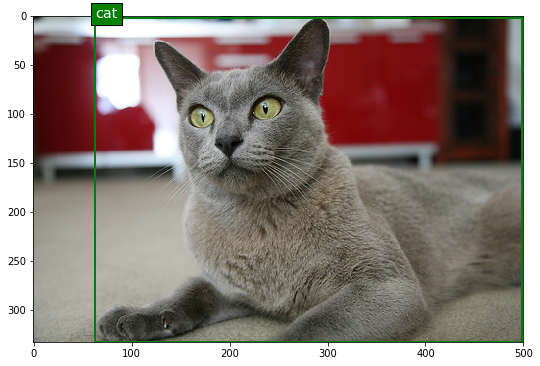

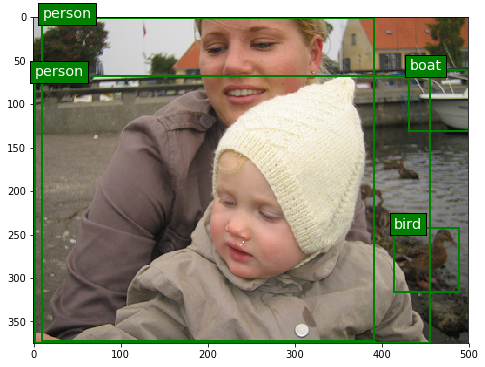

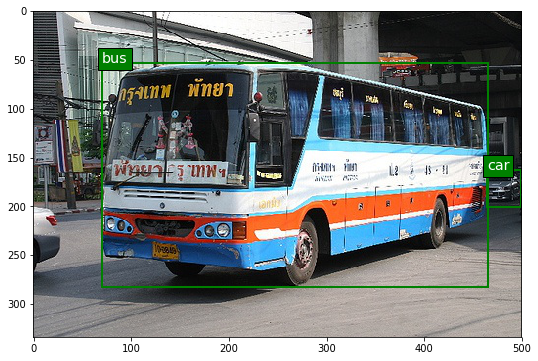

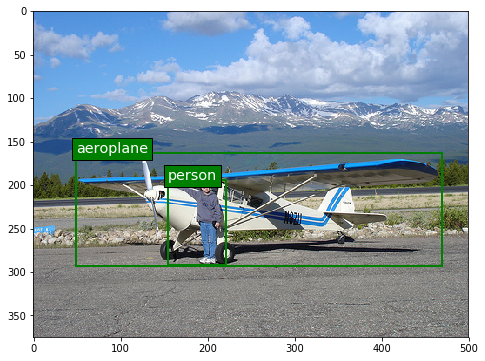

In [22]:
train_flow_origin = train_dataset.generate(batch_size = 4,
                                           transformations=[], 
                                           label_encoder = label_encoder,
                                           returns = ['original_images','original_labels'])
images,labels = next(train_flow_origin)
for img,label in zip(images, labels):
    draw_detection(img,label,class_names)           

### Debug encoder-decoder and data augment

In [58]:
import detector_help
reload(detector_help)
import ssd_encoder_decoder.ssd_output_decoder
reload(ssd_encoder_decoder.ssd_output_decoder)
from ssd_encoder_decoder.ssd_output_decoder import decode_detections
train_flow_encode = train_dataset.generate(batch_size = 8,
                                           transformations= [convert_to_3_channels,
                                                      resize], 
                                           label_encoder = label_encoder,
                                           shuffle = False,
                                           returns=["processed_images","processed_labels","encoded_labels"])

images,enc_labels,proc_labels = next(train_flow_encode) 
print(enc_labels.shape, enc_labels[0])
enc_labels_custom = detector_help.post_process(enc_labels,
                                               priors,
                                               variances,
                                               num_classes,
                                               input_H,input_W, 
                                               score_thresh = 0.06,   
                                               iou_thresh = 0.45,
                                               top_k = 1000) # Use top_k as 1000 because all gt labels`s conf are 1
enc_labels_default = decode_detections(enc_labels,
                  priors,
                  np.array(variances),
                  img_height = input_H,
                  img_width = input_W,
                  confidence_thresh = 0.06,
                  iou_threshold = 0.45)

# for img,enc_default_label,enc_custom_label,proc_label in zip(images,enc_labels_default,enc_labels_custom,proc_labels):
#     print(enc_custom_label)
#     draw_detection(img, proc_label, class_names, color = 'green')
#     #plt.title('Default decoder')
#     #draw_detection(img, enc_default_label, class_names, color = 'red')
#    # plt.title('Custom decoder')
#     draw_detection(img, enc_custom_label, class_names, color = 'purple')

(8, 2998, 25) [[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 1.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          1.         ... -0.05759696 -0.08579126
   0.48573259]
 [ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          1.         ... -0.04419417  2.05556056
  -0.83865149]]


### Set training params

In [63]:
#If load weights from files,initial_epoch need to be set to the next epoch to be trained.
initial_epoch = 2
final_epochs = 50
steps_per_epoch = 1000
plot = True

## Train the model

In [ ]:
print('model name' ,model_name , \
       '\nstart fitting.. ' , 
       'inital epoch:', initial_epoch,
       'final epoch:', final_epochs,
       'epoch step:', steps_per_epoch,
       'plot_history:' ,plot, \
       '\ntrainset size:',  train_dataset.get_dataset_size(), ' batch_size', batch_size )     

validation_steps =  val_dataset.get_dataset_size() // batch_size
history = model.fit_generator(train_generator,
                              use_multiprocessing = True, 
                              steps_per_epoch = steps_per_epoch, 
                              validation_data = val_generator,
                              validation_steps = validation_steps, 
                              epochs = final_epochs,
                              callbacks = callbacks,
                              initial_epoch = initial_epoch)

if plot:
    plot_history(history)
    plt.savefig('./rfbmn2_300_pascal07+12_train.jpg')



model name rfbmn2_300 
start fitting..  inital epoch: 2 final epoch: 50 epoch step: 1000 plot_history: True 
trainset size: 16551  batch_size 32
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 806s 806ms/step - loss: 32.3931 - class_loss: 4.8683 - loc_loss: 26.5715 - val_loss: 53.1785 - val_class_loss: 5.9717 - val_loc_loss: 46.3154
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 790s 790ms/step - loss: 31.6994 - class_loss: 4.8166 - loc_loss: 26.0284 - val_loss: 47.6025 - val_class_loss: 5.6178 - val_loc_loss: 41.1725
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 760s 760ms/step - loss: 31.2368 - class_loss: 4.7754 - loc_loss: 25.6718 - val_loss: 49.6251 - val_class_loss: 5.5316 - val_loc_loss: 43.3401
Epoch 6/50

Epoch 00006: LearningRateScheduler setting le

### Evaluate

In [104]:
import eval_utils.average_precision_evaluator
reload(eval_utils.average_precision_evaluator)
from eval_utils.average_precision_evaluator import Evaluator

In [94]:
test_dataset = DataGenerator()
test_dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                      image_set_filenames=[VOC_2007_test_image_set_filename],
                      annotations_dirs=[VOC_2007_annotations_dir],
                      classes=class_names,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=False,
                      ret=False)
print('Test size', test_dataset.get_dataset_size())

Processing image set 'test.txt': 100%|██████████| 4952/4952 [00:13<00:00, 367.98it/s]
Test size 4952


In [105]:
evaluator = Evaluator(model=model,
                      n_classes=num_classes,
                      data_generator=test_dataset,
                      model_mode='training')

results = evaluator(img_height=input_H,
                    img_width=input_W,
                    batch_size=batch_size,
                    priors = priors,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 4952



  0%|          | 0/155 [00:00<?, ?it/s]

Producing predictions batch-wise:   0%|          | 0/155 [00:00<?, ?it/s]

Producing predictions batch-wise:   1%|          | 1/155 [00:00<02:09,  1.18it/s]

Producing predictions batch-wise:   1%|▏         | 2/155 [00:01<02:00,  1.27it/s]

Producing predictions batch-wise:   2%|▏         | 3/155 [00:02<01:51,  1.36it/s]

Producing predictions batch-wise:   3%|▎         | 4/155 [00:02<01:45,  1.44it/s]

Producing predictions batch-wise:   3%|▎         | 5/155 [00:03<01:40,  1.49it/s]

Producing predictions batch-wise:   4%|▍         | 6/155 [00:04<01:40,  1.48it/s]

Producing predictions batch-wise:   5%|▍         | 7/155 [00:04<01:35,  1.54it/s]

Producing predictions batch-wise:   5%|▌         | 8/155 [00:05<01:36,  1.53it/s]

Producing predictions batch-wise:   6%|▌         | 9/155 [00:05<01:33,  1.56it/s]

Producing predictions batch-wise:   6%|▋         | 10/155 [00:06<01:33,  1.55it/s]

P

/home/cai/project/RFBNet-Keras/detector_help.py:131: RuntimeWarning: overflow encountered in exp
  boxeses[:,2] =  np.exp(loc[:,2]) * priors[:,2]
/home/cai/project/RFBNet-Keras/detector_help.py:132: RuntimeWarning: overflow encountered in exp
  boxeses[:,3] =  np.exp(loc[:,3]) * priors[:,3]




Producing predictions batch-wise:  14%|█▍        | 22/155 [00:13<01:20,  1.65it/s]

Producing predictions batch-wise:  15%|█▍        | 23/155 [00:14<01:22,  1.60it/s]

Producing predictions batch-wise:  15%|█▌        | 24/155 [00:15<01:21,  1.61it/s]

Producing predictions batch-wise:  16%|█▌        | 25/155 [00:15<01:20,  1.62it/s]

Producing predictions batch-wise:  17%|█▋        | 26/155 [00:16<01:18,  1.63it/s]

Producing predictions batch-wise:  17%|█▋        | 27/155 [00:16<01:21,  1.58it/s]

Producing predictions batch-wise:  18%|█▊        | 28/155 [00:17<01:19,  1.60it/s]

Producing predictions batch-wise:  19%|█▊        | 29/155 [00:18<01:17,  1.62it/s]

Producing predictions batch-wise:  19%|█▉        | 30/155 [00:18<01:16,  1.63it/s]

Producing predictions batch-wise:  20%|██        | 31/155 [00:19<01:17,  1.60it/s]

Producing predictions batch-wise:  21%|██        | 32/155 [00:20<01:15,  1.62it/s]

Producing predictions batch-wise:  21%|██▏       | 33/155 [00:20<01:17,  1

Matching predictions to ground truth, class 3/20.:   0%|          | 0/44842 [00:00<?, ?it/s]

Matching predictions to ground truth, class 3/20.:   2%|▏         | 875/44842 [00:00<00:05, 8744.86it/s]

Matching predictions to ground truth, class 3/20.:   4%|▍         | 1883/44842 [00:00<00:04, 9105.92it/s]

Matching predictions to ground truth, class 3/20.:   7%|▋         | 2943/44842 [00:00<00:04, 9504.83it/s]

Matching predictions to ground truth, class 3/20.:   9%|▉         | 4072/44842 [00:00<00:04, 9976.30it/s]

Matching predictions to ground truth, class 3/20.:  12%|█▏        | 5216/44842 [00:00<00:03, 10373.95it/s]

Matching predictions to ground truth, class 3/20.:  15%|█▍        | 6561/44842 [00:00<00:03, 11136.43it/s]

Matching predictions to ground truth, class 3/20.:  18%|█▊        | 8010/44842 [00:00<00:03, 11965.71it/s]

Matching predictions to ground truth, class 3/20.:  21%|██        | 9503/44842 [00:00<00:02, 12720.85it/s]

Matching predictions to ground truth, class 3/2

Matching predictions to ground truth, class 7/20.:  12%|█▏        | 29344/238739 [00:02<00:16, 13005.63it/s]

Matching predictions to ground truth, class 7/20.:  13%|█▎        | 30676/238739 [00:03<00:15, 13097.89it/s]

Matching predictions to ground truth, class 7/20.:  13%|█▎        | 32095/238739 [00:03<00:15, 13403.76it/s]

Matching predictions to ground truth, class 7/20.:  14%|█▍        | 33484/238739 [00:03<00:15, 13545.17it/s]

Matching predictions to ground truth, class 7/20.:  15%|█▍        | 34945/238739 [00:03<00:14, 13847.02it/s]

Matching predictions to ground truth, class 7/20.:  15%|█▌        | 36338/238739 [00:03<00:14, 13869.21it/s]

Matching predictions to ground truth, class 7/20.:  16%|█▌        | 37731/238739 [00:03<00:15, 12972.13it/s]

Matching predictions to ground truth, class 7/20.:  16%|█▋        | 39259/238739 [00:03<00:14, 13587.64it/s]

Matching predictions to ground truth, class 7/20.:  17%|█▋        | 40703/238739 [00:03<00:14, 13831.59it/s]

Matching p

Matching predictions to ground truth, class 9/20.:  57%|█████▋    | 53849/94574 [00:03<00:01, 22482.69it/s]

Matching predictions to ground truth, class 9/20.:  59%|█████▉    | 56107/94574 [00:03<00:01, 22505.03it/s]

Matching predictions to ground truth, class 9/20.:  62%|██████▏   | 58520/94574 [00:03<00:01, 22968.60it/s]

Matching predictions to ground truth, class 9/20.:  64%|██████▍   | 60891/94574 [00:03<00:01, 23184.40it/s]

Matching predictions to ground truth, class 9/20.:  67%|██████▋   | 63239/94574 [00:03<00:01, 23271.59it/s]

Matching predictions to ground truth, class 9/20.:  69%|██████▉   | 65650/94574 [00:03<00:01, 23515.10it/s]

Matching predictions to ground truth, class 9/20.:  72%|███████▏  | 68137/94574 [00:03<00:01, 23904.34it/s]

Matching predictions to ground truth, class 9/20.:  75%|███████▍  | 70652/94574 [00:04<00:00, 24264.52it/s]

Matching predictions to ground truth, class 9/20.:  77%|███████▋  | 73235/94574 [00:04<00:00, 24712.14it/s]

Matching prediction

Matching predictions to ground truth, class 15/20.:  30%|███       | 87948/291526 [00:08<00:18, 10735.96it/s]

Matching predictions to ground truth, class 15/20.:  31%|███       | 89169/291526 [00:08<00:18, 11139.10it/s]

Matching predictions to ground truth, class 15/20.:  31%|███       | 90368/291526 [00:08<00:17, 11378.80it/s]

Matching predictions to ground truth, class 15/20.:  31%|███▏      | 91595/291526 [00:08<00:17, 11631.38it/s]

Matching predictions to ground truth, class 15/20.:  32%|███▏      | 92812/291526 [00:09<00:16, 11785.48it/s]

Matching predictions to ground truth, class 15/20.:  32%|███▏      | 94088/291526 [00:09<00:16, 12060.60it/s]

Matching predictions to ground truth, class 15/20.:  33%|███▎      | 95343/291526 [00:09<00:16, 12199.41it/s]

Matching predictions to ground truth, class 15/20.:  33%|███▎      | 96584/291526 [00:09<00:15, 12258.75it/s]

Matching predictions to ground truth, class 15/20.:  34%|███▎      | 97815/291526 [00:09<00:15, 12225.32it/s]

M

Matching predictions to ground truth, class 16/20.:  69%|██████▊   | 35776/52094 [00:01<00:00, 24153.80it/s]

Matching predictions to ground truth, class 16/20.:  74%|███████▍  | 38450/52094 [00:02<00:00, 24874.14it/s]

Matching predictions to ground truth, class 16/20.:  79%|███████▉  | 41094/52094 [00:02<00:00, 25322.14it/s]

Matching predictions to ground truth, class 16/20.:  84%|████████▍ | 43813/52094 [00:02<00:00, 25854.43it/s]

Matching predictions to ground truth, class 16/20.:  89%|████████▉ | 46556/52094 [00:02<00:00, 26305.55it/s]

Matching predictions to ground truth, class 16/20.:  95%|█████████▍| 49366/52094 [00:02<00:00, 26817.27it/s]

Matching predictions to ground truth, class 16/20.: 100%|█████████▉| 52059/52094 [00:02<00:00, 26610.33it/s]

Matching predictions to ground truth, class 16/20.: 100%|██████████| 52094/52094 [00:02<00:00, 20771.36it/s]

  0%|          | 0/37176 [00:00<?, ?it/s]

Matching predictions to ground truth, class 17/20.:   0%|          | 0/37176 

In [108]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(class_names[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

aeroplane     AP    0.022
bicycle       AP    0.125
bird          AP    0.015
boat          AP    0.002
bottle        AP    0.0
bus           AP    0.21
car           AP    0.05
cat           AP    0.284
chair         AP    0.007
cow           AP    0.003
diningtable   AP    0.266
dog           AP    0.156
horse         AP    0.228
motorbike     AP    0.201
person        AP    0.021
pottedplant   AP    0.006
sheep         AP    0.003
sofa          AP    0.094
train         AP    0.218
tvmonitor     AP    0.024

              mAP   0.097


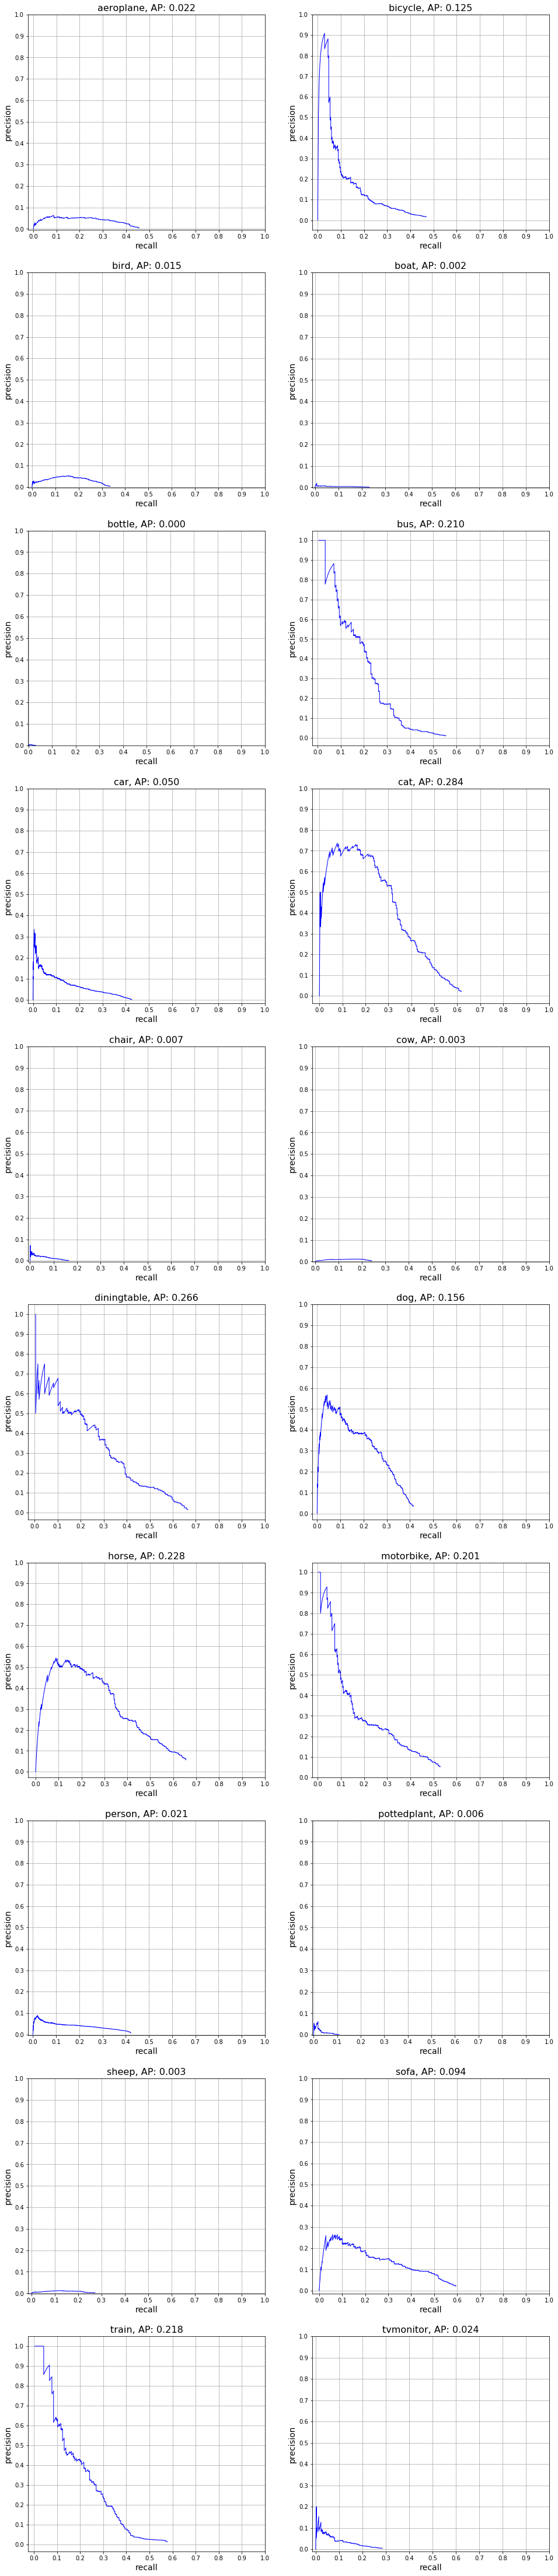

In [112]:
m = max((num_classes + 1) // 2, 2)
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > num_classes: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=14)
        cells[i, j].set_ylabel('precision', fontsize=14)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(class_names[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)

### Predict

In [33]:
# 1: Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [90]:
# 2: Generate samples.
#print(len(next(predict_generator)))
batch_images, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # Which batch item to look at

#print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))


# 3: Make predictions.
y_pred = model.predict(batch_images)


Ground truth boxes:

[[ 15  85 111 332 500]]


In [91]:
# 3: Decode labels
reload(detector_help)
y_pred_decoded = decode_detections(y_pred,
                  priors,
                  img_height = input_H,
                  img_width = input_W,
                  confidence_thresh = 0.5,
                  iou_threshold = 0.1)
# y_pred_decoded = detector_help.post_process(y_pred, 
#                                             priors,
#                                             num_classes,
#                                             input_H, 
#                                             input_W,
#                                             score_thresh = 0.5,
#                                             iou_thresh = 0.4)
y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)
np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[ 15.     0.61  19.    85.   342.   493.  ]]


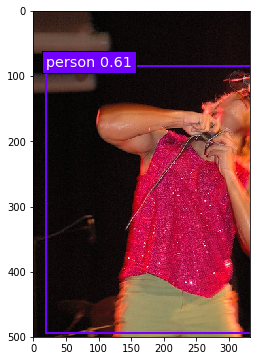

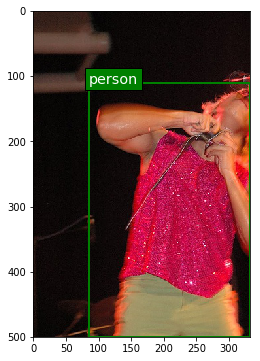

In [92]:
# 4: Draw 
colors = plt.cm.hsv(np.linspace(0, 1, num_classes+1)).tolist()
draw_detection(batch_original_images[i],y_pred_decoded_inv[i],class_names,
               show = True, draw_score = True,use_cm = True,color = colors, size = 'medium')
draw_detection(batch_original_images[i],batch_original_labels[i],class_names, size = 'medium')


### Image Demo

In [ ]:
img_file = "data/dog3.jpg"
img = cv2.imread(img_file)
img = cv2.resize(img,(224,224))
x = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = np.array(x,dtype='float')
x = x / 255
y_pred = model.predict(np.expand_dims(x,0))
y_pred = post_process(y_pred,priors,num_classes,input_H,input_W)
print(y_pred)
draw_detection(img,y_pred[0],class_names)

### Video detection demo

In [ ]:
video_file = "data/cat_video.mp4"
result_file = "res.avi"
cap= cv2.VideoCapture(video_file)
fps = cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
frames = (int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print('Input Video Size:',size,' Fps:',fps,' Frames:',frames)
writer = cv2.VideoWriter(result_file,cv2.VideoWriter_fourcc(*'MJPG'), fps, size)
success,frame = cap.read()
count = 1
while success:
    x = cv2.resize(frame,dsize=(input_H,input_W),interpolation=cv2.INTER_CUBIC)
    x = x / 255
    y_pred = model.predict(np.expand_dims(x,0))[0]
    y_pred [-4:] *= [*size,*size]
    draw_detection(frame, y_pred,class_names,font_scale = 1)
    writer.write(frame)
    cv2.waitKey(1)
    count += 1
    if count%50==0:
        print(y_pred)
        plt.imshow(frame)
        plt.show()
        print('.',end='')
    success,frame = cap.read()
print('done')